In [2]:
import pandas as pd 
import numpy as np 
import src.fold
from tqdm import tqdm 
import requests
from src.files import *
import io
from src.fold import * 
import re
from Bio.Seq import Seq
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt
import time
import tarfile 

%load_ext autoreload
%autoreload 2

ece_id = 'ece_26_1334'
genome_ids = ['methanoperedens_1', 'methanoperedens_2', ece_id]

# Convert the GenBank files to other file formats 
for genome_id in genome_ids:
    path = os.path.join('../data/', f'{genome_id}.gbk')
    genbank_file = GenBankFile.from_file(path)
    genbank_file.to_fasta(path.replace('.gbk', '.fa'))
    genbank_file.to_gff(path.replace('.gbk', '.gff'))

# sbatch --partition gpu --gpus 1 --wrap '/shared/software/bin/colabfold_batch --use-gpu-relax --amber --templates --num-recycle 3 ./data/ece_26_1334.fa ./alphafold'
# sbatch --partition gpu --gpus 1 --wrap '/shared/software/bin/colabfold_batch --use-gpu-relax --amber --templates --num-recycle 3 ./data/ece_26_1334_all_orfs.fa ./alphafold'
# rosettafold2 -o ./rosettafold ./data/ece_26_1334.fa

# srun foldseek easy-search ./foldseek/query/esmfold/ /shared/db/foldseek/latest/db/pdb ./foldseek/esmfold-ece_26_1334-pdb.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./foldseek/query/esmfold/ /shared/db/foldseek/latest/db/alphafold_uniprot ./foldseek/esmfold-ece_26_1334-uniprot.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./foldseek/query/alphafold/ /shared/db/foldseek/latest/db/pdb ./foldseek/alphafold-ece_26_1334-pdb.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64
# srun foldseek easy-search ./foldseek/query/alphafold/ /shared/db/foldseek/latest/db/alphafold_uniprot ./foldseek/alphafold-ece_26_1334-uniprot.tsv tmp/ -s 7.5 --format-mode 4 --format-output query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage --threads 64


# featureCounts -p -T 64 -g ID -t CDS -a ece_26_1334.gff -s 2 -o ./metat/n_middle_2025-ece_26_1334_read_counts ./metat/n_middle_2025-ece_26_1334.bam

In [3]:
# ! makeblastdb -in ../data/borg_family_members.faa -dbtype prot -out ../blast/databases/borg_family_members -title 'borg_family_members'

# '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
# ! blastp -query ../data/ece_26_1334.fa -db ../data/blast/databases/borg_family_members -out ../data/ece_26_1334-borg_family_members.tsv -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
# ! blastp -query ../data/ece_26_1334_all_orfs.fa -db ../data/blast/databases/borg_family_members -out ../data/ece_26_1334_all_orfs-borg_family_members.tsv -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'

In [4]:
# cols = 'qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
# blast_df = pd.read_csv('../data/blast/output/ece_26_1334-borg_family_members.tsv', sep='\t', names=cols.split(), header=None)

In [5]:
# Want to look at transcription on the strand opposite the ORFs. 

def reverse_gff_file(path:str):
    cols = ['contig_id', 'model', 'feature_type', 'start', 'stop', 'score', 'strand', 'frame', 'description']
    gff_df = pd.read_csv(path, sep='\t', names=cols, comment='#')
    gff_df['strand'] = np.where(gff_df.strand == '-', '+', '-') # Just switch all the strand signs.
    
    output_path = path.replace('.gff', '_rev.gff')
    with open(output_path, 'w') as f:
        f.write('##gff-version  3\n')
    
    gff_df.to_csv(output_path, header=None, sep='\t', index=False, mode='a') # Append to the file which already has the header. 


reverse_gff_file('../data/ece_26_1334.gff')

In [6]:
# I am honestly a bit curious about other potential proteins on the element that Prodigal may have missed. 
start_codons = ['ATG', 'GTG', 'TTG']
start_codon_pattern = f'(?=({'|'.join(start_codons)}))' # Use lookahead to support overlapping start codons. 
stop_codons = ['TAG', 'TAA', 'TGA']
ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fn').seqs[0]
ece_seq_reverse = str(Seq(ece_seq).reverse_complement())

# ece_df = FASTAFile.from_file(f'../data/{ece_id}.fa').to_df(parse_description=False)
ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()
ece_df['id'] = [f'ece_26_1334_{id_}' for id_ in ece_df.index]

ece_stops = ece_df.stop.unique()
ece_starts = ece_df.start.unique() - 1

def get_orfs(seq, strand:str='+'):
    get_codons = lambda start: np.array([seq[i:i + 3] for i in range(start, len(seq), 3)])
    orf_df = list()
    for start_codon_match in re.finditer(start_codon_pattern, seq):
        row = {'strand':strand}
        row['start'] = start_codon_match.start()
        row['start_codon'] = seq[row['start']:row['start'] + 3]
        codons = get_codons(row['start'])

        if np.any(np.isin(codons, stop_codons)):
            stop_codon_idx = np.where(np.isin(codons, stop_codons))[0][0] # Get the first instance of a stop codon.
            nt_seq = ''.join(codons[:stop_codon_idx + 1])
            row['stop'] = row['start'] + len(nt_seq)
            row['nt_seq'] = nt_seq
            row['stop_codon'] = codons[stop_codon_idx]
            row['seq'] = str(Seq(nt_seq).translate()).replace('*', '')
            orf_df.append(row)

    orf_df = pd.DataFrame(orf_df)
    orf_df['length'] = orf_df.seq.apply(len)
    orf_df = orf_df[orf_df.length > 9].copy()
    orf_df = orf_df.sort_values('length', ascending=False).groupby('stop', as_index=False).first() # Want to get the longest sequence for each stop codon. 

    if strand == '-':
        orf_df['stop'] = len(seq) - orf_df.start 
        orf_df['start'] = orf_df.stop - orf_df.nt_seq.apply(len)
    
    return orf_df

ece_all_orfs_df = pd.concat([get_orfs(ece_seq), get_orfs(ece_seq_reverse, strand='-')]).reset_index()
ece_all_orfs_df['already_predicted'] = (ece_all_orfs_df.stop.isin(ece_stops) & (ece_all_orfs_df.strand == '+')) | (ece_all_orfs_df.start.isin(ece_starts) & (ece_all_orfs_df.strand == '-'))
assert (ece_all_orfs_df.already_predicted.sum() == len(ece_df)), 'Some of the ORFs already predicted by Prodigal were not accounted for.'
ece_all_orfs_df = ece_all_orfs_df[~ece_all_orfs_df.already_predicted].copy() # Grab the new ORFs. 

ece_all_orfs_df['gene_id'] = [f'1_{i + 1 + len(ece_df)}' for i in range(len(ece_all_orfs_df))] # Start the gene numbering at 38. 
ece_all_orfs_df = ece_all_orfs_df.set_index('gene_id')
ece_all_orfs_df['id'] = [f'ece_26_1334_all_orfs_{id_}' for id_ in ece_all_orfs_df.index]



In [7]:
ece_df = [ece_df.assign(already_predicted=True)]
ece_df += [ece_all_orfs_df[~ece_all_orfs_df.already_predicted & (ece_all_orfs_df.length > 30)].copy()]
ece_df = pd.concat(ece_df)
ece_df['product'] = ece_df['product'].fillna('hypothetical protein')


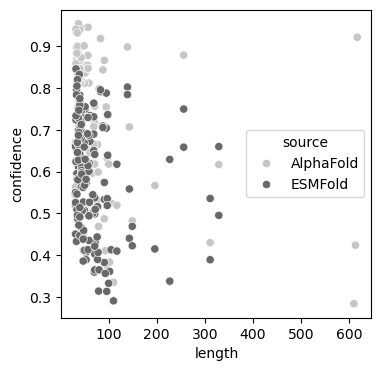

In [8]:
get_id = lambda path : re.search(r'\d+_\d+', path.replace(ece_id, '')).group(0)

figure_df = list()
for path in glob.glob('../data/structures/esmfold/*'):
    confidence, _ = fold_esm_get_confidence(path)
    figure_df.append({'confidence':confidence, 'id':get_id(path), 'source': 'ESMFold'})
for path in glob.glob('../data/structures/alphafold/*_relaxed_rank_001_alphafold2_ptm_model_*_seed_000.pdb'): # 1_9_relaxed_rank_001_alphafold2_ptm_model_2_seed_000.pdb
    confidence, _ = fold_esm_get_confidence(path)
    figure_df.append({'confidence':confidence / 100, 'id':get_id(path), 'source': 'AlphaFold'})

figure_df = pd.DataFrame(figure_df)
figure_df['length'] = figure_df['id'].map(ece_df.seq.apply(len))
figure_df = figure_df.sort_values('source')

fig, ax = plt.subplots(figsize=(4, 4))
# sns.kdeplot(figure_df, x='confidence', hue='prodigal', common_norm=False)
sns.scatterplot(figure_df, x='length', y='confidence', hue='source', ax=ax, palette='Grays')
plt.show()

In [9]:
for input_path in glob.glob('../data/structures/esmfold/*'):
    if 'trimmed' in input_path:
        continue
    fold_trim_structure(input_path, min_b_score=0.5, save=True)

# For Foldseek, should be using the relaxed AlphaFold structure for folding. Also should make sure to use the most highly-ranked model. 
for input_path in glob.glob('../data/structures/alphafold/*pdb'):
    if ('trimmed' in input_path) or (not (('_relaxed_' in input_path) and ('rank_001' in input_path))):
        continue
    gene_id = '_'.join(os.path.basename(input_path).split('_')[:2])
    output_path = os.path.join(os.path.dirname(input_path), f'{gene_id}_trimmed.pdb')
    if not os.path.exists(output_path):
        fold_trim_structure(input_path, output_path=output_path, min_b_score=50, save=True)


fold_trim_structure: Kept 28 out of 28 residues from ../data/structures/esmfold/1_275.pdb.
fold_trim_structure: Kept 29 out of 30 residues from ../data/structures/esmfold/1_314.pdb.
fold_trim_structure: Kept 18 out of 18 residues from ../data/structures/esmfold/1_261.pdb.
fold_trim_structure: Kept 18 out of 18 residues from ../data/structures/esmfold/1_203.pdb.
fold_trim_structure: Kept 26 out of 26 residues from ../data/structures/esmfold/1_133.pdb.
fold_trim_structure: Kept 34 out of 34 residues from ../data/structures/esmfold/1_178.pdb.
fold_trim_structure: Kept 39 out of 40 residues from ../data/structures/esmfold/1_54.pdb.
fold_trim_structure: Kept 21 out of 23 residues from ../data/structures/esmfold/1_370.pdb.
fold_trim_structure: Kept 16 out of 16 residues from ../data/structures/esmfold/1_377.pdb.
fold_trim_structure: Kept 20 out of 20 residues from ../data/structures/esmfold/1_63.pdb.
fold_trim_structure: Kept 16 out of 16 residues from ../data/structures/esmfold/1_119.pdb.
f

In [10]:
# def load_foldseek(path, max_e_value:int=1):
#     fields = 'query,target,theader,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov,taxid,taxname,taxlineage'.split(',')
#     foldseek_df = pd.read_csv(path, sep='\t') #, names=fields)
#     foldseek_df = foldseek_df[foldseek_df['evalue'] < max_e_value].copy()
#     foldseek_df = foldseek_df.sort_values('evalue')
#     return foldseek_df

# foldseek_df = list()
# for path in glob.glob('../data/foldseek/*'):
#     database, source = path.split('-')[-1].replace('.tsv', ''), path.split('-')[0]
#     foldseek_df.append(load_foldseek(path).assign(database=database, source=source))
# foldseek_df = pd.concat(foldseek_df)
# foldseek_df['gene_id'] = foldseek_df['query'].apply(get_id)
# foldseek_df['gene_number'] = foldseek_df.gene_id.apply(lambda id_ : int(id_.split('_')[1]))
# foldseek_df['original_prediction'] = foldseek_df.gene_number <= 38

# print('Num. proteins with reasonable Foldseek hits:', foldseek_df.gene_id.nunique())
# print('Num. original proteins with reasonable Foldseek hits:', foldseek_df[foldseek_df.original_prediction].gene_id.nunique(), end='\n\n')

# for gene_id in foldseek_df.gene_id.unique():
#     print(gene_id)

# 1_47 https://www.nature.com/articles/nchembio.2359

In [11]:
# Not super happy with the results of Foldseek queries against PDB and UniProt. Going to try against the BFVD. 

output_dir = '../data/foldseek/esmfold/'
gene_ids = [f'1_{i}' for i in range(1, 39)]
paths = [os.path.join('../data/structures/esmfold/', f'{gene_id}_trimmed.pdb') for gene_id in gene_ids]
paths = [path for path in paths if os.path.exists(path)]

In [12]:
def foldseek_load(path):
   archive = tarfile.open(path, mode='r:gz')
   cols = ['query_id','subject_id','identity','alignment_length', 'mismatch', 'gap_open', 'query_alignment_start', 'query_alignment_stop', 'subject_alignment_start', 'subject_alignment_stop']
   cols += ['tm_score', 'e_value','bit_score', 'query_length', 'subject_length',  'query_alignment', 'subject_alignment', 'per_residue_lddt', 'subject_seq', 'subject_taxonomy_id', 'subject_species_name']
   
   foldseek_df = list()
   for member in archive.getmembers():
      if ('report' in member.name):
         continue 
      f = archive.extractfile(member)
      content = f.read().decode('utf-8')
      df = pd.read_csv(io.StringIO(content), sep='\t', names=cols)
      df['database'] = member.name.replace('.m8', '').replace('alis_', '')
      if len(df) > 0:
         foldseek_df.append(df)

   if len(foldseek_df) == 0:
      return None 
   
   foldseek_df = pd.concat(foldseek_df).reset_index(drop=True)
   foldseek_df['query_id'] = get_id(path) # Replace the query ID with the actual name. 
   foldseek_df['subject_species_name'] = foldseek_df['subject_species_name'].fillna('none')
   return foldseek_df

esmfold_foldseek_df = pd.concat([foldseek_load(path) for path in glob.glob('../data/foldseek/esmfold/*')])
alphafold_foldseek_df = pd.concat([foldseek_load(path) for path in glob.glob('../data/foldseek/alphafold/*')])


In [41]:
print('Alphafold structures with Foldseek hits:', ', '.join(alphafold_foldseek_df[alphafold_foldseek_df.tm_score > 0.5].query_id.unique()))
print('Num. Alphafold structures with Foldseek hits:', alphafold_foldseek_df[alphafold_foldseek_df.tm_score > 0.5].query_id.nunique())
print('ESMFold structures with Foldseek hits:', ', '.join(esmfold_foldseek_df[esmfold_foldseek_df.tm_score > 0.5].query_id.unique()))
print('Num. ESMFold structures with Foldseek hits:', esmfold_foldseek_df[esmfold_foldseek_df.tm_score > 0.5].query_id.nunique())

Alphafold structures with Foldseek hits: 1_35, 1_22, 1_34, 1_25, 1_28, 1_37, 1_32, 1_17, 1_19, 1_16, 1_1, 1_3, 1_38, 1_21, 1_14, 1_11, 1_20, 1_23, 1_33, 1_12, 1_26, 1_2, 1_5
Num. Alphafold structures with Foldseek hits: 23
ESMFold structures with Foldseek hits: 1_35, 1_10, 1_8, 1_28, 1_37, 1_32, 1_17, 1_1, 1_3, 1_38, 1_21, 1_14, 1_33, 1_12, 1_2
Num. ESMFold structures with Foldseek hits: 15


In [14]:
def extend(start:int, stop:int, max_extension_length:int=50, frame_shift:int=0, start_codons=['ATG', 'GTG', 'TTG']):
    print(f'extend: Original sequence length is {(stop - start) // 3}')
    extended_start = (start - frame_shift) - (3 * max_extension_length)
    seq = ece_seq[extended_start:start - frame_shift] + ece_seq[start:stop]
    codons = [seq[i:i + 3] for i in range(0, len(seq), 3)]
    start_idx = np.where(np.isin(codons, start_codons))[0][0] # Select the left-most start codon. 
    seq = Seq(''.join(codons[start_idx:])).translate()
    print(f'extend: New sequence length is {len(seq)}')
    return str(seq)

start, stop = 2194 - 1, 2331
extend(start, stop, frame_shift=3)

extend: Original sequence length is 46
extend: New sequence length is 93


'MPMLYIWRTIYNPSITL*STFSRYRKEN*RTSD*TGYRYIRERMECVMNIKECTDIELIEEMKKRNLHFHIDYIQMTLSLNNIKVKTFAVKS*'

In [93]:
min_tm_score = 0.5

def foldseek_print_info(gene_id:str, foldseek_df:pd.DataFrame=None, min_tm_score:float=min_tm_score, top_n:int=1000):
    # df = foldseek_df[foldseek_df.query_id == gene_id].sort_values('tm_score', ascending=False).copy()
    df = foldseek_df[foldseek_df.query_id == gene_id].sort_values('e_value', ascending=True).copy()
    df = df[df.tm_score > min_tm_score].copy()
    # df = df[~df.database.str.contains('mgnify')].copy()
    # df = df[df.database.str.contains('BFVD')].copy()
    df = df.iloc[:min(len(df), top_n)].copy()
    for row in df.itertuples():
        print(row.database, f'E-value {row.e_value}', f'TM score {row.tm_score:.2f}')
        print(row.subject_species_name, row.subject_id)
        subject_coverage = (row.subject_alignment_stop - row.subject_alignment_start) / row.subject_length
        query_coverage = (row.query_alignment_stop - row.query_alignment_start) / row.query_length
        print('subject alignment:', f'{row.subject_alignment_start} - {row.subject_alignment_stop} ({subject_coverage * 100:.2f}%)')
        print('query alignment:', f'{row.query_alignment_start} - {row.query_alignment_stop} ({query_coverage * 100:.2f}%)')
        print()

# Need to look into how E-values are computed and why the results vary so substantially from the TM-scores. 

# 1_23 
# afdb50 E-value 9.657 TM score 0.77
# Plasmodium inui San Antonio 1 AF-W7A0L2-F1-model_v6 Ribosome recycling factor
# subject alignment: 228 - 278 (17.36%)
# query alignment: 34 - 84 (52.08%)

# 1_28
# afdb50 E-value 2.595 TM score 0.84
# marine sediment metagenome AF-X1UHT3-F1-model_v6 Ribosome recycling factor domain-containing protein (Fragment)
# subject alignment: 1 - 84 (90.22%)
# query alignment: 12 - 96 (52.83%)

gene_id = '1_14'
foldseek_print_info(gene_id, foldseek_df=alphafold_foldseek_df)
# foldseek_print_info(gene_id, foldseek_df=esmfold_foldseek_df)


bfmd E-value 0.6919 TM score 0.51
Homo sapiens ProtVar_Q5VTD9_Q96PM5_A
subject alignment: 289 - 330 (12.42%)
query alignment: 2 - 40 (92.68%)

afdb-swissprot E-value 1.084 TM score 0.54
Rattus norvegicus AF-Q07120-F1-model_v6 Zinc finger protein Gfi-1
subject alignment: 381 - 423 (9.93%)
query alignment: 1 - 40 (95.12%)

afdb-swissprot E-value 1.084 TM score 0.57
Canis lupus familiaris AF-Q5DWN0-F1-model_v6 Zinc finger protein Gfi-1
subject alignment: 383 - 422 (9.24%)
query alignment: 2 - 40 (92.68%)

afdb-swissprot E-value 1.162 TM score 0.54
Mus musculus AF-P70338-F1-model_v6 Zinc finger protein Gfi-1
subject alignment: 381 - 423 (9.93%)
query alignment: 1 - 40 (95.12%)

BFVD E-value 1.213 TM score 0.51
Halovirus HCTV-5 R4T7H2_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000
subject alignment: 22 - 61 (20.00%)
query alignment: 6 - 41 (85.37%)

afdb-swissprot E-value 1.336 TM score 0.51
Mus musculus AF-Q3U288-3-F1-model_v6 Zinc finger protein 710
subject alignment: 561 - 604 (6.67%

In [16]:
# Also trying annotation with BLAST against NCBI and Borg proteins. 
# None of the non-Prodigal predictions had any hits in NCBI. 
blast_df = BLASTFileJSON().from_file('../data/ncbi-ece_26_1334.json').to_df()
blast_df['database'] = 'ncbi'

def load_blast(path):
    cols = 'qseqid sseqid pident length A0A4Z0H468mismatch gapopen qstart qend sstart send evalue bitscore qlen slen qcovhsp'
    blast_df = pd.read_csv(path, sep='\t', names=cols.split())
    blast_df = blast_df.rename(columns={'qseqid':'id', 'sseqid':'subject_id', 'qstart':'query_alignment_start', 'qend':'query_alignment_stop'})
    blast_df = blast_df.rename(columns={'length':'alignment_length', 'bitscore':'bit_score', 'sstart':'subject_alignment_start', 'send':'subject_alignment_stop'})
    blast_df = blast_df.rename(columns={'pident':'identity', 'evalue':'e_value', 'qlen':'query_length', 'slen':'subject_length'})
    return blast_df.drop(columns=['gapopen', 'qcovhsp'])

blast_df = pd.concat([blast_df, load_blast('../data/ece_26_1334_all_orfs-borg_family_members.tsv').assign(database='borgs')])
blast_df = pd.concat([blast_df, load_blast('../data/ece_26_1334-borg_family_members.tsv').assign(database='borgs')])
blast_df['id'] = blast_df['id'].str.replace(ece_id, '1')
blast_df['gene_number'] = blast_df['id'].apply(lambda id_ : int(id_.split('_')[1]))

blast_df = blast_df[blast_df.bit_score > 40].copy()
print('Num. proteins with BLAST hits:', blast_df['id'].nunique())

Num. proteins with BLAST hits: 12


/tmp/ipykernel_51872/762399847.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  blast_df = pd.concat([blast_df, load_blast('../data/ece_26_1334-borg_family_members.tsv').assign(database='borgs')])


In [17]:
blast_df[blast_df.gene_number == 27]#.subject_id.tolist()

,subject_id,id,subject_description,subject_taxon,subject_taxonomy_id,bit_score,e_value,identity,positive,subject_alignment_start,...,n_gaps,alignment_length,query_seq,subject_seq,subject_length,query_length,alignment,database,A0A4Z0H468mismatch,gene_number
236,MDO9354834,1_27,hypothetical protein [Solirubrobacteraceae bac...,Solirubrobacteraceae bacterium,2586742.0,67.3958,7.867810e-08,98.0,177.0,67,...,44.0,374,ITTDKTAYNLGDII-FENYTIANADTYN--FLYTIRTYDENNILIS...,ISFNKSFYSLYDVINFSYHIMDNSTTHNTYYIKTIQTEKS----TG...,407,610,I+ +K+ Y+L D+I F + + N+ T+N ++ TI+T ...,ncbi,NaN,27
